In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder \
    .appName("AirQualityMonitoring") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .getOrCreate()

# Define the schema
schema = StructType([
    StructField("State Code", IntegerType(), True),
    StructField("County Code", IntegerType(), True),
    StructField("Site Num", IntegerType(), True),
    StructField("Parameter Code", IntegerType(), True),
    StructField("POC", IntegerType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Datum", StringType(), True),
    StructField("Parameter Name", StringType(), True),
    StructField("Date Local", StringType(), True),
    StructField("Time Local", StringType(), True),
    StructField("Date GMT", StringType(), True),
    StructField("Time GMT", StringType(), True),
    StructField("Sample Measurement", DoubleType(), True),
    StructField("Units of Measure", StringType(), True),
    StructField("MDL", DoubleType(), True),
    StructField("Uncertainty", StringType(), True),
    StructField("Qualifier", StringType(), True),
    StructField("Method Type", StringType(), True),
    StructField("Method Code", IntegerType(), True),
    StructField("Method Name", StringType(), True),
    StructField("State Name", StringType(), True),
    StructField("County Name", StringType(), True),
    StructField("Date of Last Change", StringType(), True)
])

# Read CSV data with the defined schema
air_quality_data = spark.read.csv("aqdata.csv", header=True, schema=schema)

# Create a DateTime column by merging Date Local and Time Local, and convert it to a timestamp
air_quality_data = air_quality_data.withColumn(
    "DateTime",
    to_timestamp(expr("concat(`Date Local`, ' ', `Time Local`)"), "yyyy-MM-dd H:mm")
)


In [2]:
unique_parameter_names = air_quality_data.select("Parameter Name").distinct().collect()

# Print the unique parameter names
for row in unique_parameter_names:
    print(row["Parameter Name"])

Ozone
Nitrogen dioxide (NO2)
Sulfur dioxide
Carbon monoxide


In [3]:
from pyspark.sql.functions import first

# Group by Latitude, Longitude, and Timestamp and apply conditional aggregation
pivoted_data = air_quality_data.groupBy("Latitude", "Longitude", "DateTime") \
    .agg(
        first(when(col("Parameter Name") == "Ozone", col("Sample Measurement")), ignorenulls=True).alias("O3"),
        first(when(col("Parameter Name") == "Nitrogen dioxide (NO2)", col("Sample Measurement")), ignorenulls=True).alias("NO2"),
        first(when(col("Parameter Name") == "Sulfur dioxide", col("Sample Measurement")), ignorenulls=True).alias("SO2"),
        first(when(col("Parameter Name") == "Carbon monoxide", col("Sample Measurement")), ignorenulls=True).alias("CO")
    )

pivoted_data.show(10)



+---------+----------+-------------------+-----+----+----+----+
| Latitude| Longitude|           DateTime|   O3| NO2| SO2|  CO|
+---------+----------+-------------------+-----+----+----+----+
|34.289001|-85.970065|2022-01-01 04:00:00|0.018|null|null|null|
|34.289001|-85.970065|2022-01-06 12:00:00|0.023|null|null|null|
|34.289001|-85.970065|2022-01-09 10:00:00|0.025|null|null|null|
|34.289001|-85.970065|2022-01-12 10:00:00|0.036|null|null|null|
|33.904039|-86.053867|2022-03-05 12:00:00|0.061|null|null|null|
|33.904039|-86.053867|2022-03-06 01:00:00| 0.03|null|null|null|
|33.904039|-86.053867|2022-03-08 13:00:00|0.028|null|null|null|
|33.904039|-86.053867|2022-03-11 06:00:00|0.013|null|null|null|
|33.553056|   -86.815|2022-01-07 05:00:00|0.027| 2.6| 0.1| 0.2|
|33.485556|   -86.915|2022-03-04 16:00:00|0.072|null| 0.9| 0.0|
+---------+----------+-------------------+-----+----+----+----+
only showing top 10 rows



In [4]:
def get_shape(df):
    row_count = df.count()
    column_count = len(df.columns)
    return row_count, column_count
row_count, column_count = get_shape(pivoted_data)
print(f"Shape of the DataFrame: ({row_count}, {column_count})")

Shape of the DataFrame: (41589657, 7)


In [5]:
cleaned_data = pivoted_data.dropna()


In [6]:
row_count, column_count = get_shape(cleaned_data)
print(f"Shape of the DataFrame: ({row_count}, {column_count})")

Shape of the DataFrame: (2066750, 7)


In [7]:
""" unique_lat_lng = air_quality_data.select("Latitude", "Longitude").distinct()
unique_coords_pd = unique_lat_lng.toPandas()
unique_coords_pd.to_csv('unique_coords.csv', index=False) """

' unique_lat_lng = air_quality_data.select("Latitude", "Longitude").distinct()\nunique_coords_pd = unique_lat_lng.toPandas()\nunique_coords_pd.to_csv(\'unique_coords.csv\', index=False) '

In [8]:
from pyspark.sql.functions import to_timestamp

weather_data = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("historical_weather_data.csv")


In [9]:
weather_data = weather_data.withColumnRenamed("Latitude", "lat").withColumnRenamed("Longitude", "lng")

weather_data.show(5)

+---------+---------+-------------------+-----------+--------+-------------+----------+
|      lat|      lng|          timestamp|temperature|humidity|precipitation|wind_speed|
+---------+---------+-------------------+-----------+--------+-------------+----------+
|36.843425|-121.3621|2019-01-01 00:00:00|       51.1|      38|          0.0|      3.71|
|36.843425|-121.3621|2019-01-01 01:00:00|       49.5|      41|          0.0|       3.0|
|36.843425|-121.3621|2019-01-01 02:00:00|       47.5|      44|          0.0|      2.75|
|36.843425|-121.3621|2019-01-01 03:00:00|       45.8|      45|          0.0|      3.04|
|36.843425|-121.3621|2019-01-01 04:00:00|       43.8|      47|          0.0|       2.9|
+---------+---------+-------------------+-----------+--------+-------------+----------+
only showing top 5 rows



In [10]:
# Join air quality and weather data based on lat and lng and datetime
joined_data = cleaned_data.join(weather_data, (cleaned_data.Latitude == weather_data.lat) & \
                                            (cleaned_data.Longitude == weather_data.lng) & \
                                            (cleaned_data.DateTime == weather_data.timestamp), "inner")

In [11]:
joined_data = joined_data.drop("lat").drop("lng").drop("timestamp")


In [12]:
joined_data=joined_data.dropna()
row_count, column_count = get_shape(joined_data)
print(f"Shape of the DataFrame: ({row_count}, {column_count})")

Shape of the DataFrame: (2067007, 11)


In [13]:
# Extract year, month, day, and hour from the DateTime column
joined_data = joined_data.withColumn("Year", year(col("DateTime"))) \
    .withColumn("Month", month(col("DateTime"))) \
    .withColumn("Day", dayofmonth(col("DateTime"))) \
    .withColumn("Hour", hour(col("DateTime")))



In [14]:
from pyspark.sql import Window
from pyspark.sql.functions import lag

# Define the window partitioning and ordering
window_spec = Window.partitionBy("Latitude", "Longitude").orderBy("DateTime")

# Create lag features for O3, temperature, and humidity for 1, 3, and 6 hours before the current hour
joined_data = joined_data.withColumn("O3_lag_1h", lag("O3", 1).over(window_spec))
joined_data = joined_data.withColumn("O3_lag_3h", lag("O3", 3).over(window_spec))
joined_data = joined_data.withColumn("O3_lag_6h", lag("O3", 6).over(window_spec))

joined_data = joined_data.withColumn("temperature_lag_1h", lag("temperature", 1).over(window_spec))
joined_data = joined_data.withColumn("temperature_lag_3h", lag("temperature", 3).over(window_spec))
joined_data = joined_data.withColumn("temperature_lag_6h", lag("temperature", 6).over(window_spec))

joined_data = joined_data.withColumn("humidity_lag_1h", lag("humidity", 1).over(window_spec))
joined_data = joined_data.withColumn("humidity_lag_3h", lag("humidity", 3).over(window_spec))
joined_data = joined_data.withColumn("humidity_lag_6h", lag("humidity", 6).over(window_spec))

# Remove rows with null values in the lag features
joined_data = joined_data.dropna()


In [15]:
""" joined_data.write.format("csv").option("header", True).mode("overwrite").save("./final_data.csv") """

' joined_data.write.format("csv").option("header", True).mode("overwrite").save("./final_data.csv") '

In [16]:
# Import required libraries
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Define the features to be used for prediction
feature_cols = ['NO2', 'SO2', 'CO', 'temperature', 'humidity', 'precipitation', 'wind_speed',
                'O3_lag_1h', 'O3_lag_3h', 'O3_lag_6h', 'temperature_lag_1h', 'temperature_lag_3h',
                'temperature_lag_6h', 'humidity_lag_1h', 'humidity_lag_3h', 'humidity_lag_6h']

# Create a vector assembler to transform features to vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform the data using vector assembler
data = assembler.transform(joined_data)

# Split the data into training and testing sets (70/30 split)
train_data, test_data = data.randomSplit([0.7, 0.3], seed=123)

# Create a GBTRegressor model with default parameters
gbt = GBTRegressor(featuresCol="features", labelCol="O3")

# Train the model on the training data
model = gbt.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using RMSE
evaluator = RegressionEvaluator(labelCol="O3", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

# Print the RMSE
print("RMSE:", rmse)



RMSE: 0.004680788970506573


In [22]:
test_data.show(10)

+---------+----------+-------------------+-----+----+---+---+-----------+--------+-------------+----------+----+-----+---+----+---------+---------+---------+------------------+------------------+------------------+---------------+---------------+---------------+--------------------+
| Latitude| Longitude|           DateTime|   O3| NO2|SO2| CO|temperature|humidity|precipitation|wind_speed|Year|Month|Day|Hour|O3_lag_1h|O3_lag_3h|O3_lag_6h|temperature_lag_1h|temperature_lag_3h|temperature_lag_6h|humidity_lag_1h|humidity_lag_3h|humidity_lag_6h|            features|
+---------+----------+-------------------+-----+----+---+---+-----------+--------+-------------+----------+----+-----+---+----+---------+---------+---------+------------------+------------------+------------------+---------------+---------------+---------------+--------------------+
|34.510961|-117.32554|2019-01-01 08:00:00|0.035| 3.5|0.5|0.3|       30.7|      41|          0.0|      3.77|2019|    1|  1|   8|    0.036|    0.036| 

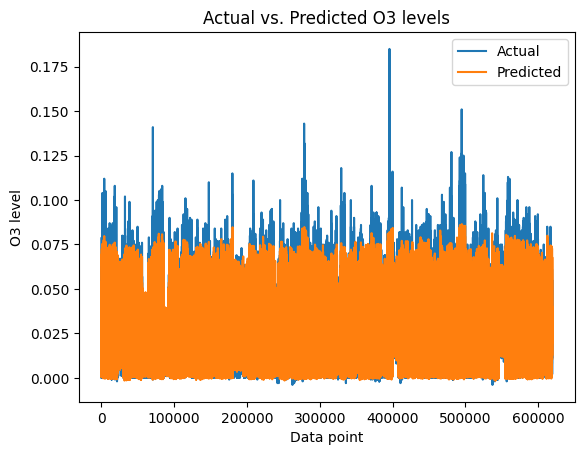

In [23]:
import matplotlib.pyplot as plt

# Extract the actual and predicted values
actual = predictions.select("O3").collect()
predicted = predictions.select("prediction").collect()

# Plot the actual and predicted values
plt.plot(actual, label="Actual")
plt.plot(predicted, label="Predicted")
plt.xlabel("Data point")
plt.ylabel("O3 level")
plt.title("Actual vs. Predicted O3 levels")
plt.legend()
plt.show()


In [17]:
""" model.save("./o3_predictor.model") """

' model.save("./o3_predictor.model") '

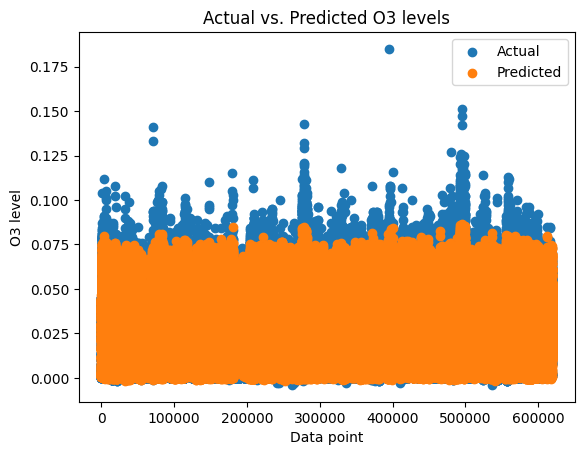

In [24]:
import matplotlib.pyplot as plt

# Extract the actual and predicted values
actual = predictions.select("O3").collect()
predicted = predictions.select("prediction").collect()

# Plot the actual and predicted values
plt.scatter(range(len(actual)), actual, label="Actual")
plt.scatter(range(len(predicted)), predicted, label="Predicted")
plt.xlabel("Data point")
plt.ylabel("O3 level")
plt.title("Actual vs. Predicted O3 levels")
plt.legend()
plt.show()

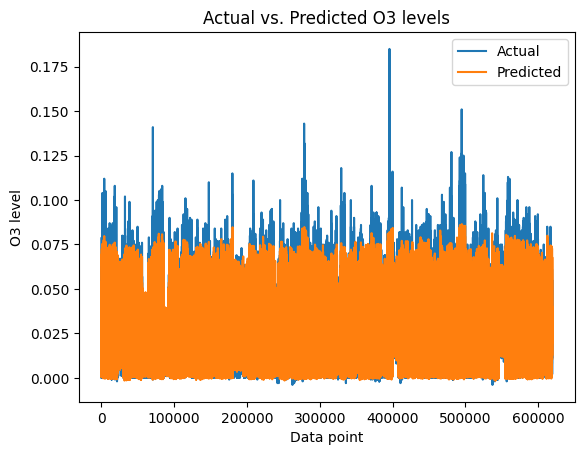

In [25]:
import matplotlib.pyplot as plt

# Extract the actual and predicted values
actual = predictions.select("O3").collect()
predicted = predictions.select("prediction").collect()

# Plot the actual and predicted values
plt.plot(actual, label="Actual")
plt.plot(predicted, label="Predicted")
plt.xlabel("Data point")
plt.ylabel("O3 level")
plt.title("Actual vs. Predicted O3 levels")
plt.legend()
plt.show()


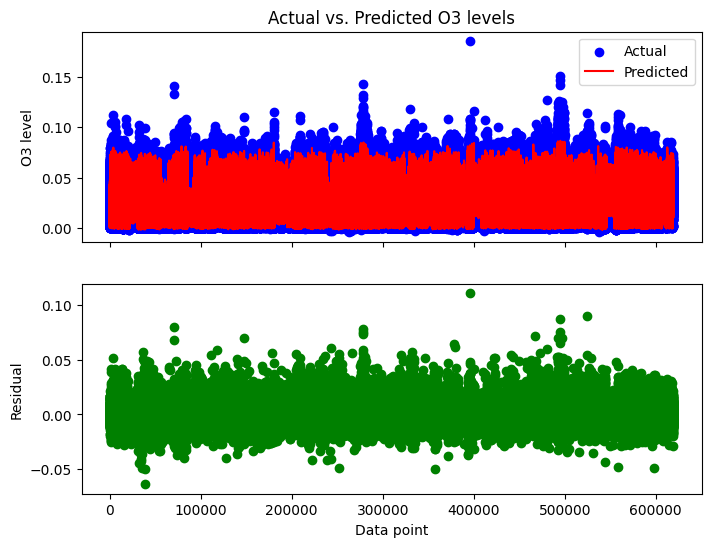

In [26]:
import matplotlib.pyplot as plt

# Extract the actual and predicted values
actual = predictions.select("O3").collect()
predicted = predictions.select("prediction").collect()

# Create a figure with two subplots
fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))

# Plot the actual values as a scatter plot
ax[0].scatter(range(len(actual)), actual, label="Actual", color="b")

# Plot the predicted values as a line plot
ax[0].plot(predicted, label="Predicted", color="r")

# Set the title and labels for the first subplot
ax[0].set_title("Actual vs. Predicted O3 levels")
ax[0].set_ylabel("O3 level")
ax[0].legend()

# Plot the residuals as a scatter plot
residuals = [actual[i][0] - predicted[i][0] for i in range(len(actual))]
ax[1].scatter(range(len(residuals)), residuals, color="g")

# Set the labels for the second subplot
ax[1].set_xlabel("Data point")
ax[1].set_ylabel("Residual")

# Show the plot
plt.show()
